# Smart Scheduling
**Goal**: Use existing patterns in attendance and academic performance to simulate alternative scheduling strategies (e.g., shifting certain courses, grouping high-engagement sessions earlier/later) to optimize expected attendance.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your attendance dataset
attendance_df = pd.read_csv('attendance_feie.csv')

# Clean column names
attendance_df.columns = (
    attendance_df.columns.str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('à', 'a')
    .str.replace('è', 'e')
    .str.replace('é', 'e')
    .str.replace('ò', 'o')
    .str.replace('ç', 'c')
    .str.replace('ñ', 'n')
    .str.replace('á', 'a')
    .str.replace('í', 'i')
    .str.replace('ó', 'o')
    .str.replace('ú', 'u')
)

## Engagement Score

In [2]:
# Step 1: Create group label
attendance_df['grup_estudi'] = attendance_df['titulacio'] + " - " + attendance_df['curs'].astype(str) + " - " + attendance_df['horari']

# Step 2: Calculate total attendance and engagement
session_cols = [col for col in attendance_df.columns if col.startswith(('s')) and any(char.isdigit() for char in col)]
attendance_df['attendance_total'] = attendance_df[session_cols].sum(axis=1)
attendance_df['attendance_rate'] = (
    attendance_df['attendance_total'] /
    (attendance_df['num_sessions'] * attendance_df['matricules-assignatura'])
)
attendance_df['engagement_score'] = 0.5 * attendance_df['attendance_rate'] + 0.5 * attendance_df['taxa_de_rendiment']

# Example: Check ADE 3rd year morning
ade_3_mati = attendance_df[attendance_df['grup_estudi'].str.contains("ADE - 1 - mati")]

# Show attendance and engagement per subject
summary = ade_3_mati[['assignatura', 'attendance_rate', 'taxa_de_rendiment', 'engagement_score']].sort_values(by='engagement_score', ascending=False)
print(summary)

                        assignatura  attendance_rate  taxa_de_rendiment  \
118                 Matemàtiques II         0.684444              0.844   
51                    Estadística I         0.626374              0.890   
40           Economia Internacional         0.531250              0.896   
89   Introducció a la comptabilitat         0.683333              0.742   

     engagement_score  
118          0.764222  
51           0.758187  
40           0.713625  
89           0.712667  


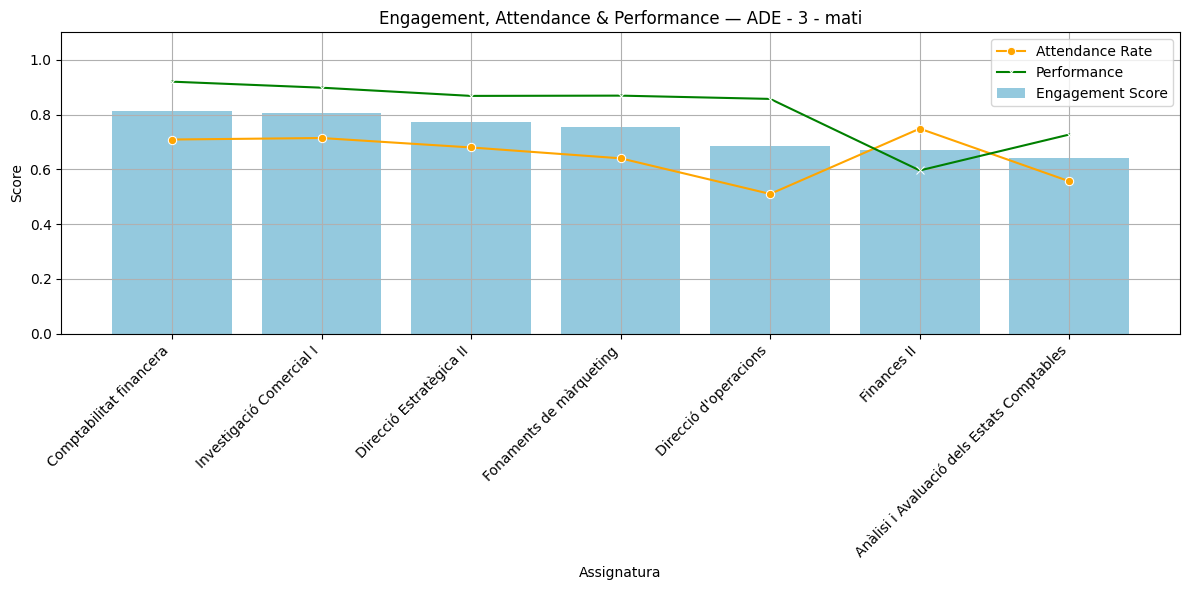

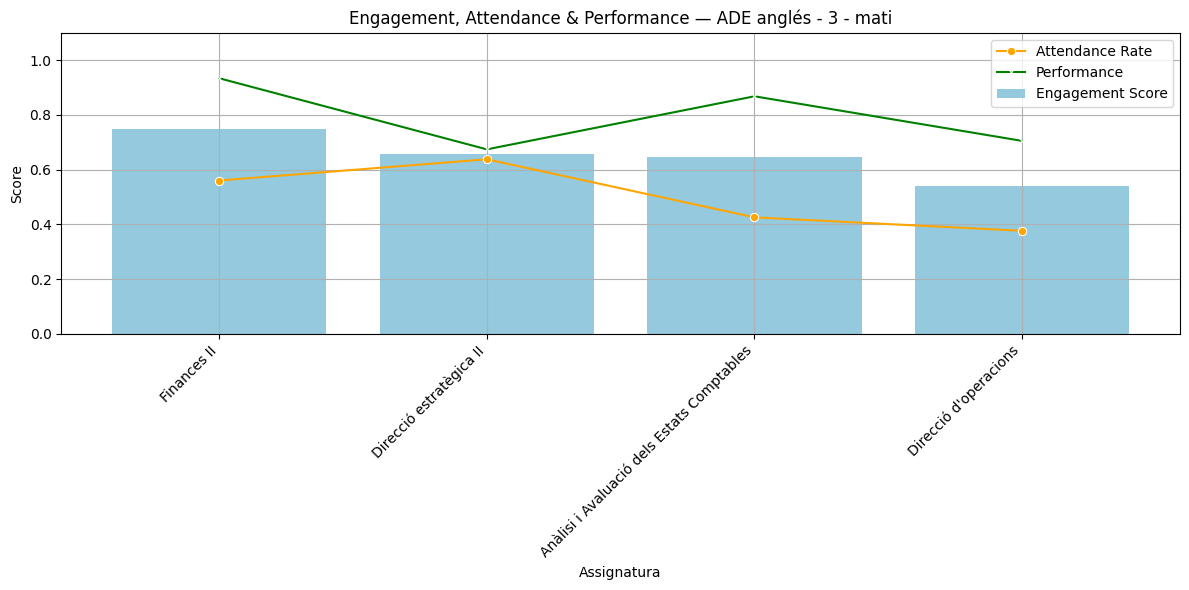

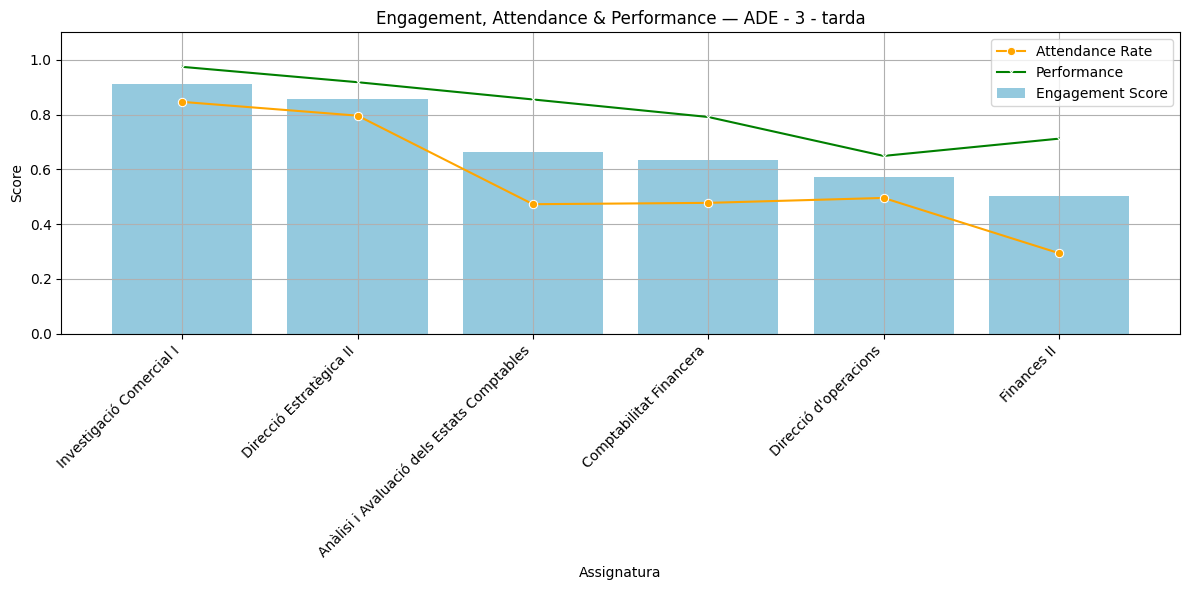

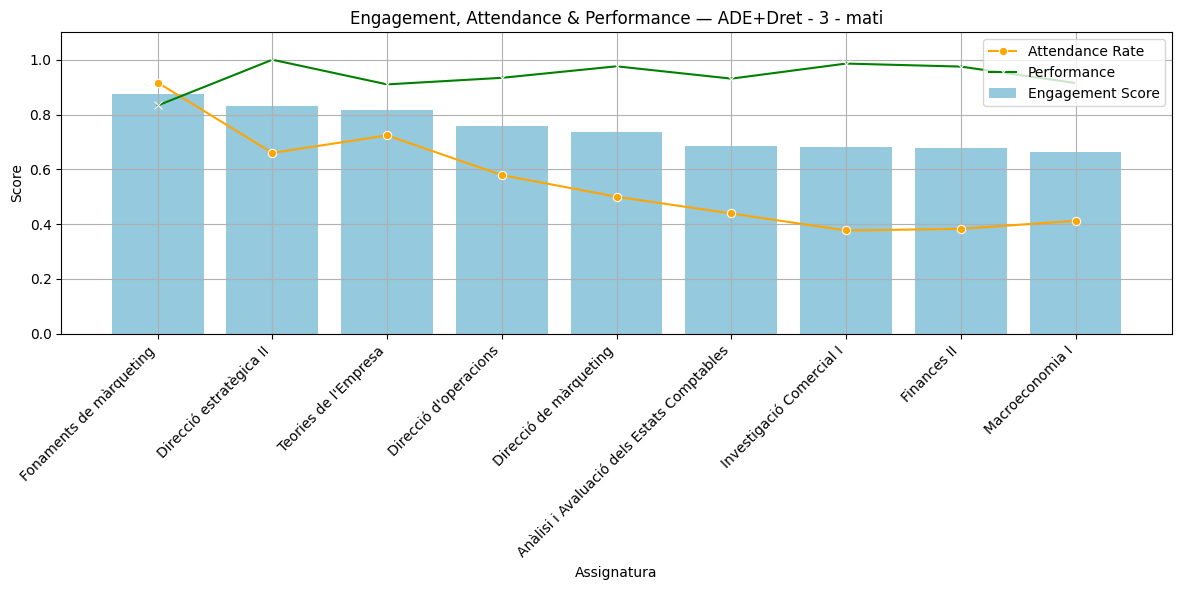

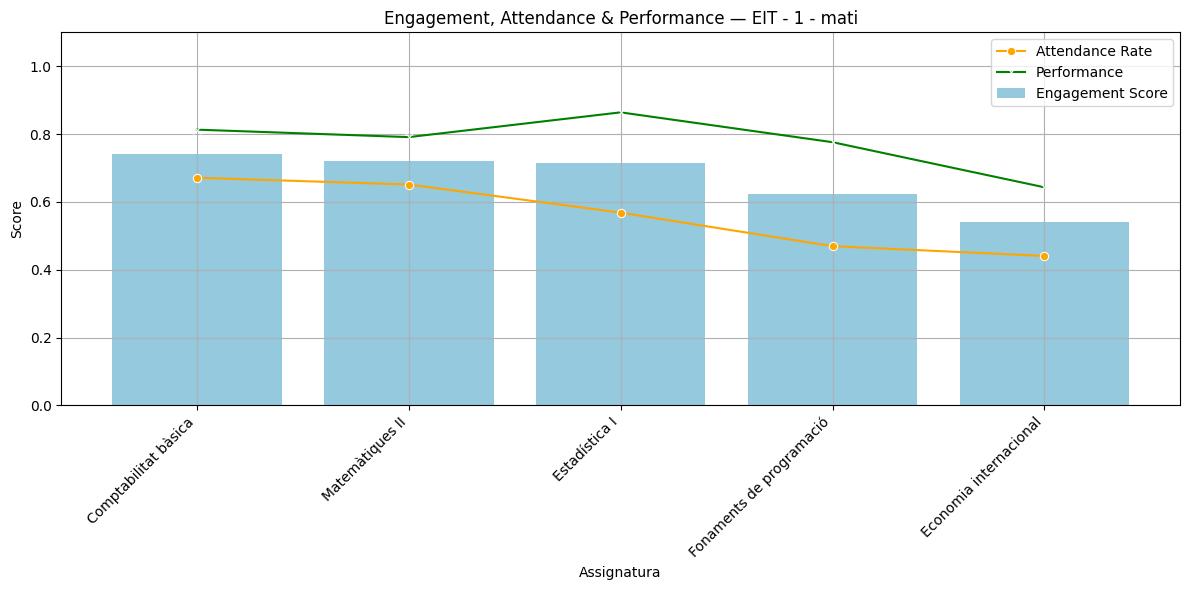

In [ ]:
group_labels = attendance_df['grup_estudi'].dropna().unique()

# Loop over groups and generate a plot per group
for group in group_labels[:5]:
    group_df = attendance_df[attendance_df['grup_estudi'] == group]

    if group_df.empty:
        continue

    # Sort subjects by engagement
    sorted_subjects = group_df.sort_values(by="engagement_score", ascending=False)

    # Set up plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=sorted_subjects, x='assignatura', y='engagement_score', color='skyblue', label='Engagement Score')
    sns.lineplot(data=sorted_subjects, x='assignatura', y='attendance_rate', color='orange', marker='o', label='Attendance Rate')
    sns.lineplot(data=sorted_subjects, x='assignatura', y='taxa_de_rendiment', color='green', marker='x', label='Performance')

    plt.title(f"Engagement, Attendance & Performance — {group}")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Score")
    plt.xlabel("Assignatura")
    plt.ylim(0, 1.1)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)

    plt.show()

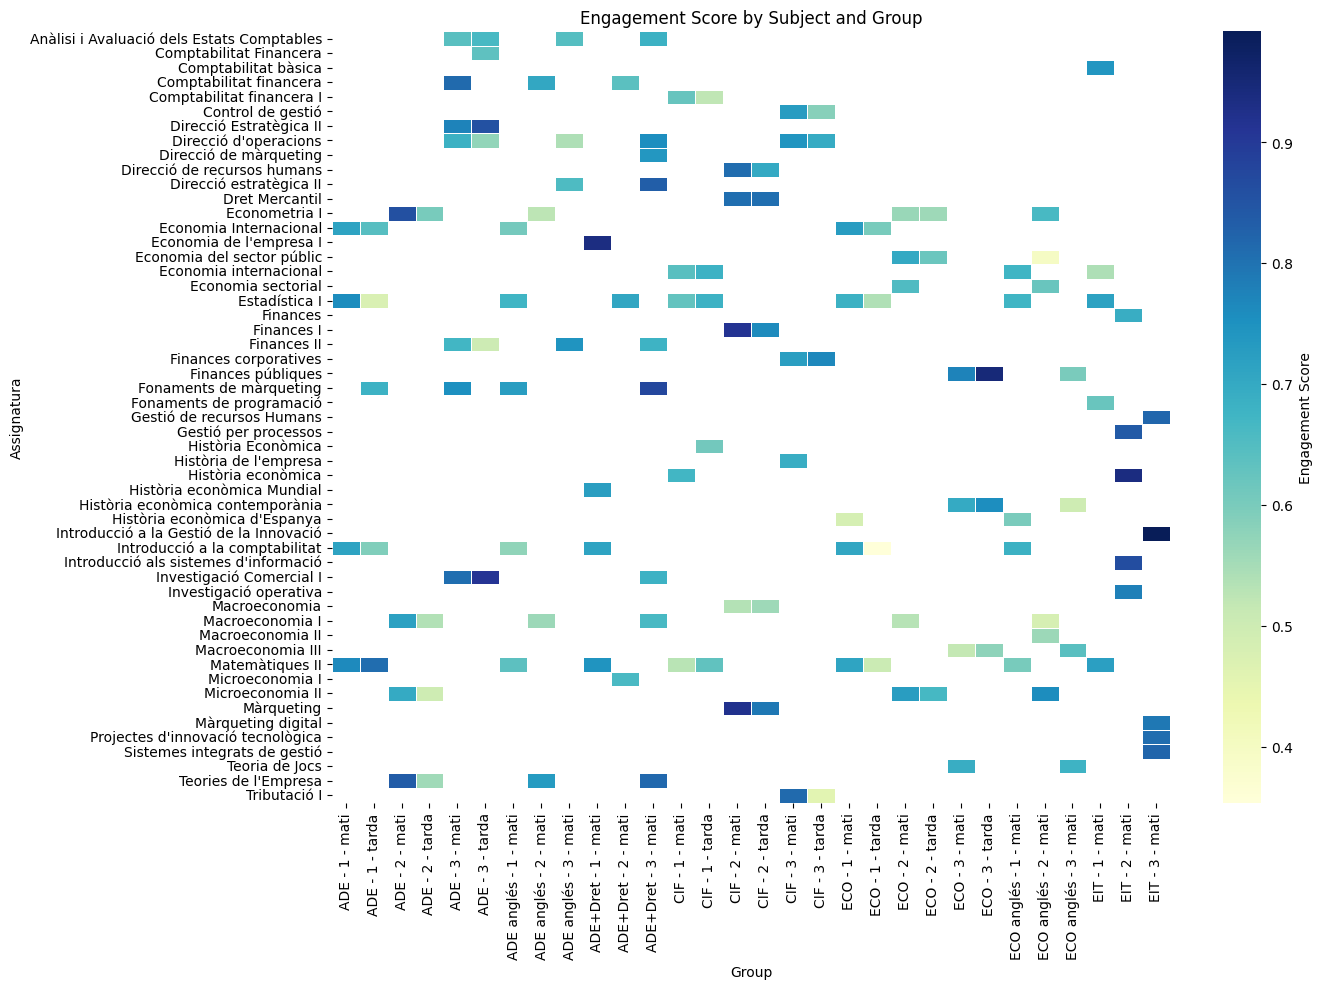

In [4]:
# Pivot: rows=assignatures, columns=grup_estudi, values=engagement_score
pivot_heatmap = attendance_df.pivot_table(
    index='assignatura', columns='grup_estudi', values='engagement_score', aggfunc='mean'
)

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_heatmap, annot=False, cmap='YlGnBu', linewidths=0.5, cbar_kws={'label': 'Engagement Score'})
plt.title("Engagement Score by Subject and Group")
plt.xlabel("Group")
plt.ylabel("Assignatura")
plt.tight_layout()
plt.show()

## Predictive Modeling

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Drop rows with missing engagement score
df_model = attendance_df.dropna(subset=['engagement_score'])

# Select relevant features
cat_features = ['titulacio', 'horari', 'campus', 'assignatura', 'sexe_docent']
num_features = ['matricules-assignatura', 'curs', 'num_sessions', 'tipologia']

df_encoded = pd.get_dummies(df_model[cat_features], drop_first=True)

X = pd.concat([df_encoded, df_model[num_features].reset_index(drop=True)], axis=1)
y = df_model['engagement_score']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R² Score: 0.3070945901024781
RMSE: 0.09922885671072407


**FEATURE IMPORTANCE**

Feature ranking:
1. matricules-assignatura (0.1834)
2. curs (0.1013)
3. num_sessions (0.0835)
4. tipologia (0.0524)
5. horari_tarda (0.0506)
6. assignatura_Finances I (0.0336)
7. assignatura_Economia de l'empresa I (0.0327)
8. assignatura_Macroeconomia I (0.0322)
9. titulacio_ECO anglés (0.0316)
10. assignatura_Economia del sector públic (0.0290)


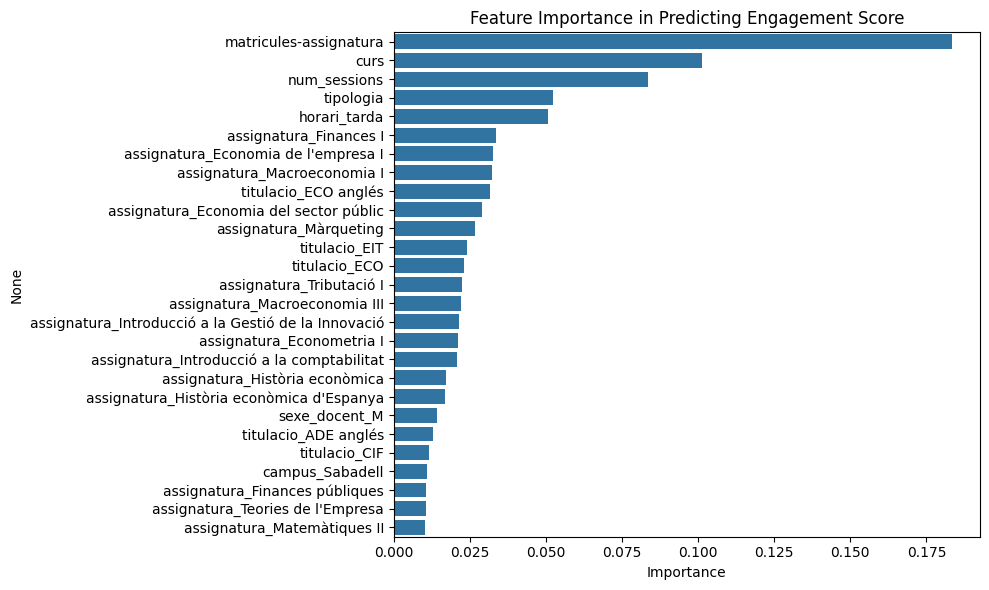

In [7]:
importances = model.feature_importances_    
feature_names = X.columns
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(10):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]:.4f})")

importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
importances = importances[importances > 0.01]  # Filter out low importance features

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance in Predicting Engagement Score")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

C:\Users\danie\AppData\Local\Temp\ipykernel_10940\595401655.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs_values, y=top_coefs_values.index, palette='coolwarm')


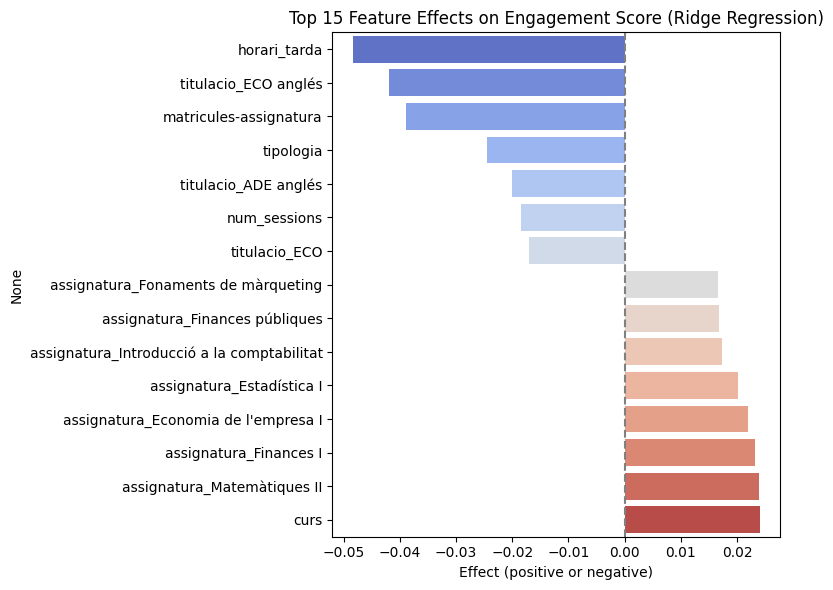

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Ridge regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_scaled, y)

# Get coefficients as a Series
coefs = pd.Series(ridge.coef_, index=X.columns)

# Select top 10 by absolute value
top_coefs = coefs.abs().sort_values(ascending=False).head(15).index
top_coefs_values = coefs.loc[top_coefs].sort_values()  # Sort for nicer plot

# Plot top coefficients
plt.figure(figsize=(8, 6))
sns.barplot(x=top_coefs_values, y=top_coefs_values.index, palette='coolwarm')
plt.axvline(0, color='gray', linestyle='--')
plt.title("Top 15 Feature Effects on Engagement Score (Ridge Regression)")
plt.xlabel("Effect (positive or negative)")
plt.tight_layout()
plt.show()


## Optimization Approach
Assign each subject in a group (titulacio + curs + horari) to a session/time slot.

**Objective**: Maximize total (or average) engagement score across all subjects in their assigned slots.

**Constraints**:
- Each subject assigned exactly one slot.
- No overlapping sessions for subjects in the same group if needed.
- Possibly limit number of sessions per day or per timeslot.

In [9]:
# Create a simplified subjects DataFrame per group
def schedule_group_subjects(group_df):
    # Extract unique subjects for the group with relevant info
    subjects = group_df[['assignatura', 'engagement_score', 'num_sessions']].drop_duplicates().reset_index(drop=True)
    
    # Number of sessions = max num_sessions among subjects (or define a fixed number)
    total_sessions = int(subjects['num_sessions'].max())
    
    # Threshold for high/low engagement subjects in this group
    high_threshold = subjects['engagement_score'].quantile(0.75)
    
    high_eng = subjects[subjects['engagement_score'] >= high_threshold].copy()
    low_eng = subjects[subjects['engagement_score'] < high_threshold].copy()
    
    # Initialize schedule dict: session_num -> list of subjects
    schedule = {session_num: [] for session_num in range(1, total_sessions + 1)}
    
    # Assign high engagement subjects first, distributing evenly across sessions
    for i, row in high_eng.iterrows():
        sessions_to_assign = int(row['num_sessions'])
        for j in range(sessions_to_assign):
            session_num = ((i + j) % total_sessions) + 1
            schedule[session_num].append(row['assignatura'])
    
    # Assign low engagement subjects, also distributed but trying to place in sessions with high engagement
    for i, row in low_eng.iterrows():
        sessions_to_assign = int(row['num_sessions'])
        for j in range(sessions_to_assign):
            # Find sessions that already have high engagement subjects
            high_eng_sessions = [k for k, subs in schedule.items() if any(h in high_eng['assignatura'].values for h in subs)]
            if high_eng_sessions:
                # Assign to one of the high engagement sessions cyclically
                session_num = high_eng_sessions[(i + j) % len(high_eng_sessions)]
            else:
                # If no high engagement sessions yet, assign cyclically to any session
                session_num = ((i + j) % total_sessions) + 1
            schedule[session_num].append(row['assignatura'])
    
    return schedule


# Apply to all groups
grouped = attendance_df.groupby('grup_estudi')

all_schedules = {}
for group_name, group_data in grouped:
    all_schedules[group_name] = schedule_group_subjects(group_data)

# Example print for a single group
example_group = list(all_schedules.keys())[0]
print(f"Schedule for group {example_group}:")
for session, subjects in all_schedules[example_group].items():
    print(f" Session {session}: {subjects}")

Schedule for group ADE - 1 - mati:
 Session 1: ['Matemàtiques II', 'Economia Internacional', 'Introducció a la comptabilitat']
 Session 2: ['Matemàtiques II', 'Economia Internacional', 'Estadística I']
 Session 3: ['Matemàtiques II', 'Economia Internacional', 'Estadística I', 'Introducció a la comptabilitat']
 Session 4: ['Matemàtiques II', 'Economia Internacional', 'Estadística I', 'Introducció a la comptabilitat']
 Session 5: ['Matemàtiques II', 'Estadística I', 'Introducció a la comptabilitat']


Find subject combinations in the same session (e.g., S11, S12, ...) that are associated with high or low attendance within a group. This reveals synergy or conflict between subjects.

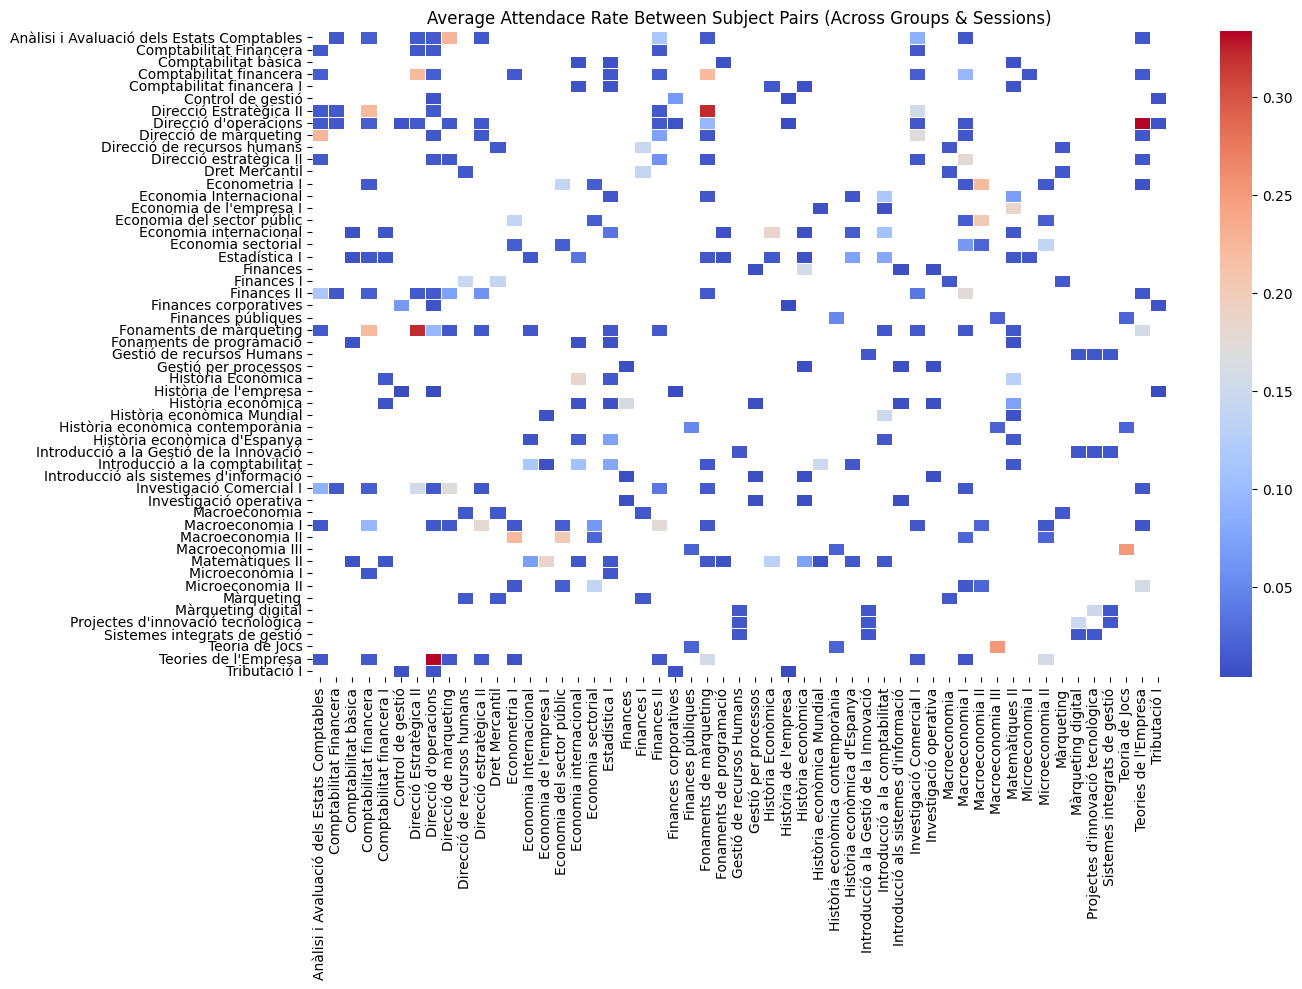

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# Step 1: Reshape to long format
def melt_attendance(attendance_df):
    melted = attendance_df.melt(
        id_vars=['assignatura', 'grup_estudi', 'matricules-assignatura'],
        value_vars=session_cols,
        var_name='session_code',
        value_name='attendance_raw'
    )
    melted = melted.dropna(subset=['attendance_raw'])
    melted = melted[melted['matricules-assignatura'] > 0]
    
    # Normalize attendance
    melted['attendance_rate'] = melted['attendance_raw'] / melted['matricules-assignatura']
    
    return melted

melted_df = melt_attendance(attendance_df)

# Step 2: Group by group + session to get all subjects done together
grouped_sessions = melted_df.groupby(['grup_estudi', 'session_code'])

# Step 3: Build a co-occurrence matrix weighted by attendance
from collections import defaultdict

cooc = defaultdict(lambda: defaultdict(float))
counts = defaultdict(lambda: defaultdict(int))

for (group, session), group_data in grouped_sessions:
    subjects = group_data['assignatura'].tolist()
    attendance_avg = group_data['attendance_rate'].mean()  # or use sum if preferred

    for subj1, subj2 in combinations(sorted(set(subjects)), 2):
        cooc[subj1][subj2] += attendance_avg
        cooc[subj2][subj1] += attendance_avg
        counts[subj1][subj2] += 1
        counts[subj2][subj1] += 1

# Step 4: Create DataFrame for heatmap
subject_list = sorted(set(melted_df['assignatura']))
cooc_matrix = pd.DataFrame(index=subject_list, columns=subject_list)

for s1 in subject_list:
    for s2 in subject_list:
        if counts[s1][s2] > 0:
            cooc_matrix.loc[s1, s2] = cooc[s1][s2] / counts[s1][s2]
        else:
            cooc_matrix.loc[s1, s2] = None

cooc_matrix = cooc_matrix.astype(float)

# Step 5: Visualize
plt.figure(figsize=(14, 10))
sns.heatmap(cooc_matrix, cmap='coolwarm', annot=False, fmt=".1f", linewidths=0.5)
plt.title("Average Attendace Rate Between Subject Pairs (Across Groups & Sessions)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [17]:
print(melted_df.head())

                                   assignatura          grup_estudi  \
3   Anàlisi i Avaluació dels Estats Comptables  ADE+Dret - 3 - mati   
10                     Comptabilitat financera  ADE+Dret - 2 - mati   
13                      Direcció de màrqueting  ADE+Dret - 3 - mati   
16                       Direcció d'operacions       CIF - 3 - mati   
19                       Direcció d'operacions      CIF - 3 - tarda   

    matricules-assignatura session_code  attendance  
3                       72          s11        41.0  
10                      66          s11        40.0  
13                      84          s11        54.0  
16                      72          s11        40.0  
19                      41          s11        26.0  
